# **Trabajo Práctico N° 1 Aprendizaje Automático II 2024**

### **Redes Densas y Convolucionales**  
**PROBLEMA 3**

---
**Alumnos:**


*   **Fontana Gustavo**
*   **Leguiza Claudia**



## **Librerías**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import zipfile
import json
import tensorflow as tf
from pathlib import Path
import gdown
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from keras.layers import Input, RandomFlip, BatchNormalization, Flatten, Dropout, RandomTranslation, RandomContrast
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation, MaxPooling2D, GlobalMaxPooling2D, Rescaling, Add
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image
from tensorflow.keras.models import load_model

## **Configuración inicial**

In [2]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


## **Carga del dataset**

In [ ]:
# LINK DE LOS DATASETS
url = 'https://drive.google.com/drive/folders/1IJ5Fo_l12Gqkoy4_3u5ufob81_OqCJ7N?usp=drive_link'

# DESCARGAR Y GUARDAR EN EL ENTORNO
gdown.download(url, quiet=True, output='NATURAL-SCENES-DATASET')
with zipfile.ZipFile('NATURAL-SCENES-DATASET', 'r') as zip_ref: zip_ref.extractall('./TP1-EJ3')

FolderContentsMaximumLimitError: The gdrive folder with url: https://drive.google.com/drive/folders/1XYgL6t5WNw3zaBP1Tze2LOg_uxLME2Cl?hl=en has more than 50 files, gdrive can't download more than this limit.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Directorio de los datos
TRAIN_DIRECTORY = Path("/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3/seg_train/seg_train")
TEST_DIRECTORY = Path("/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3/seg_test/seg_test")
PRED_DIRECTORY = Path("/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3/seg_pred/seg_pred")

In [5]:
# Tamaño del lote (batch size)
batch_size = 32

# Tamaño de las imágenes
image_height = 56
image_width = 56

# Número de clases
num_clases = 6

In [6]:
# Carga los datos de entrenamiento (80%) y validación (20%)
train = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIRECTORY,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size,
    label_mode="categorical"
)

val = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIRECTORY,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size,
    label_mode="categorical"
)

# Carga los datos de prueba
test = tf.keras.utils.image_dataset_from_directory(
    TEST_DIRECTORY,
    image_size=(image_height, image_width),
    batch_size=batch_size,
    label_mode="categorical"
)

# Cargar los datos para predicción
pred = tf.keras.utils.image_dataset_from_directory(
    PRED_DIRECTORY,
    image_size=(image_height, image_width),
    batch_size=batch_size,
    label_mode=None
)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.
Found 3000 files belonging to 6 classes.
Found 7302 files.


In [7]:
# Aplicar caché, mezcla y precarga para el conjunto de entrenamiento
train_prefetch = train.cache().shuffle(14034).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Aplicar caché y precarga para el conjunto de validación
val_prefetch = val.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## **Información del dataset**

In [8]:
# Obtiene los nombres de las clases
class_names = train.class_names
num_classes = len(class_names)

f'El total de clases del dataset es {num_classes}, las cuales son {class_names}'

"El total de clases del dataset es 6, las cuales son ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']"

In [ ]:
labels_freq = []

# Iterar sobre todo el conjunto de datos de entrenamiento
for images, labels in train:
    # Obtener las clases reales
    real_classes = np.argmax(labels.numpy(), axis=1)
    labels_freq.extend(real_classes)

KeyboardInterrupt: 

In [ ]:
# Calcular la frecuencia absoluta
frequencies = np.bincount(labels_freq)

# Calcular la frecuencia relativa
relative_frequencies = frequencies / len(labels_freq)

# Crear el DataFrame
df = pd.DataFrame({
    'Clase': np.arange(len(frequencies)),
    'Frec_Absoluta': frequencies,
    'Frec_Relativa': relative_frequencies
})

# Mostrar el DataFrame
print(df)

,Clase,Frec_Absoluta,Frec_Relativa


In [ ]:
pd['Clase'] = class_names

,Clase,Frec_Absoluta,Frec_Relativa
0,buildings,NaN,NaN
1,forest,NaN,NaN
2,glacier,NaN,NaN
3,mountain,NaN,NaN
4,sea,NaN,NaN
5,street,NaN,NaN


## **Visualización**

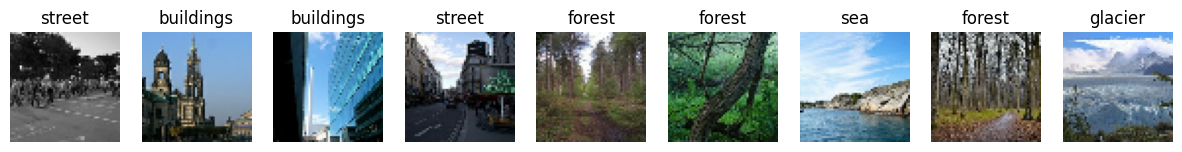

In [ ]:
# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(15, 5))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(1, 9, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")

## **Funciones para evaluar modelos**

In [ ]:
# Evaluar la pérdida y precisión del modelo
def model_evaluate(model, test_data, model_history):

    # Evaluar el modelo en el conjunto de prueba
    test_loss, test_accuracy = model.evaluate(test_data, verbose=0)

    # Promedio de la pérdida y precisión en todas las épocas (entrenamiento)
    avg_train_loss = np.mean(model_history['loss'][-10:])
    avg_train_accuracy = np.mean(model_history['accuracy'][-10:])

    # Crear un DataFrame vacío con columnas y filas para rellenar después
    df = pd.DataFrame(columns=['Train', 'Test'], index=['loss', 'accuracy'])

    # Rellenar el DataFrame con los valores calculados
    df.loc['loss', 'Train'] = avg_train_loss
    df.loc['accuracy', 'Train'] = avg_train_accuracy
    df.loc['loss', 'Test'] = test_loss
    df.loc['accuracy', 'Test'] = test_accuracy

    return df

In [ ]:
# Graficar matriz de confusión
def conf_matrix_or_report(model, test_data, target_names, conf_matrix=True):
  all_predictions = []
  all_real_labels = []

  # Iterar sobre todo el conjunto de datos de prueba
  for images, labels in test_data:
      # Realizar predicciones sobre este batch
      predictions = model.predict(images, verbose=False)

      # Obtener las clases predichas
      predicted_classes = np.argmax(predictions, axis=1)
      all_predictions.extend(predicted_classes)

      # Obtener las clases reales
      real_classes = np.argmax(labels.numpy(), axis=1)
      all_real_labels.extend(real_classes)

  if conf_matrix:
    # Matriz de confusión
    conf_matrix = confusion_matrix(all_real_labels, all_predictions)

    # Graficar
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.show()

  else:
    # Reporte de clasificación
    report = classification_report(all_real_labels, all_predictions,
                                   target_names=class_names, output_dict=True)

    df_classification_report = round(pd.DataFrame(report).transpose(),3)
    return df_classification_report

In [ ]:
# Graficar evolucion de perdida y precision en train y val
def metrics_compare_plot(model_history, total_epochs):
  # Precisión y perdida de entrenamiento y validación
  train_acc = model_history['accuracy']
  val_acc = model_history['val_accuracy']

  loss = model_history['loss']
  val_loss = model_history['val_loss']

  epochs_range = range(total_epochs)

  # Graficar la precisión y pérdida de entrenamiento y validación
  plt.figure(figsize=(20, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, train_acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [ ]:
# Función para visualizar las predicciones y valores reales sobre imágenes de ejemplo
def image_predict(model, class_names, test_data, pred=False):
    # Mostrar 9 imágenes con sus clases reales y predichas
    fig, axes = plt.subplots(1, 9, figsize=(16, 4))
    axes = axes.ravel()

    # Tomamos un lote de imágenes del conjunto de prueba
    for images, labels in test_data.take(1):
        for i, ax in enumerate(axes):
            # Mostrar la imagen
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis('off')

            # Hacer la predicción para una sola imagen
            image = tf.expand_dims(images[i], axis=0)  # Agrega una dimensión de lote
            prediction = model.predict(image, verbose=0)
            predicted_class_index = np.argmax(prediction)
            predicted_class = class_names[predicted_class_index]

            # Mostrar las clases reales y predichas, dependiendo de 'pred'
            if not pred:
                # Obtener la clase real
                actual_class = class_names[np.argmax(labels[i])]
                # Mostrar el resultado
                ax.set_title(f"Real: {actual_class}\nPred: {predicted_class}")
                plt.suptitle("Predicciones de imágenes sobre el conjunto de test", y=0.9, fontsize=16)
            else:
                # Mostrar solo la clase predicha
                ax.set_title(f"Pred: {predicted_class}")
                plt.suptitle("Predicciones de imágenes sobre el conjunto de pred", y=0.9, fontsize=16)

    # Ajustar el diseño general después de procesar todas las imágenes
    plt.show()

## **Modelo de capas densas**

In [ ]:
# Construir el modelo
dense_model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(image_height, image_width, 3)),
        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(128, activation="relu",
                              kernel_regularizer=tf.keras.regularizers.l2(1e-3)),

        tf.keras.layers.Dropout(0.01),
        tf.keras.layers.Dense(64, activation="relu"),

        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

# Callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')

# Compilación
dense_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
# Número de épocas de entrenamiento
epoch = 150

# Entrena el modelo
dense_history = dense_model.fit(
    train_prefetch,
    validation_data= val_prefetch,
    epochs=epoch,
    batch_size=batch_size,
    callbacks = [early_stopping]
)

Epoch 1/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 540s 2s/step - accuracy: 0.3037 - loss: 30.7421 - val_accuracy: 0.3485 - val_loss: 7.0388
Epoch 2/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3617 - loss: 6.8539 - val_accuracy: 0.4159 - val_loss: 4.6791
Epoch 3/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3938 - loss: 5.0829 - val_accuracy: 0.3945 - val_loss: 3.8295
Epoch 4/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4051 - loss: 4.0660 - val_accuracy: 0.4013 - val_loss: 3.5603
Epoch 5/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4228 - loss: 3.7155 - val_accuracy: 0.4024 - val_loss: 3.2029
Epoch 6/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4232 - loss: 3.2270 - val_accuracy: 0.3464 - val_loss: 4.0444
Epoch 7/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4406 - loss: 2.8404 - val_accuracy: 0.4148 - val_loss: 3.0603
Epoch 8/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4389 - loss: 2.6249 - val_ac

In [ ]:
# Construir el modelo
dense_model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(image_height, image_width, 3)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu",
                              kernel_regularizer=tf.keras.regularizers.l2(1e-3)),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

# Callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')

# Compilación
dense_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
# Entrena el modelo
dense_history = dense_model.fit(
    train_prefetch,
    validation_data= val_prefetch,
    epochs=epoch,
    batch_size=batch_size,
    callbacks = [early_stopping]
)

Epoch 1/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 2970s 2s/step - accuracy: 0.2541 - loss: 34.7957 - val_accuracy: 0.1892 - val_loss: 2.0907
Epoch 2/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1830 - loss: 2.0753 - val_accuracy: 0.1810 - val_loss: 2.0672
Epoch 3/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1870 - loss: 2.0345 - val_accuracy: 0.1896 - val_loss: 2.0424
Epoch 4/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2128 - loss: 1.9991 - val_accuracy: 0.2316 - val_loss: 1.9703
Epoch 5/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2088 - loss: 1.9750 - val_accuracy: 0.2071 - val_loss: 2.0009
Epoch 6/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2267 - loss: 1.9699 - val_accuracy: 0.2156 - val_loss: 1.9842
Epoch 7/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2121 - loss: 1.9817 - val_accuracy: 0.2334 - val_loss: 1.9688
Epoch 8/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2121 - loss: 1.9732 - val_a

### **Interpretación:**

1.  **Estructura del modelo:** Se eligió una arquitectura sencilla de red neuronal densa con dos capas ocultas de 128 y 64 neuronas respectivamente. La función de activación utilizada en las capas ocultas es ReLU, mientras que en la capa de salida se utilizó Softmax, dado que el problema consiste en una clasificación multiclase de seis categorías.

2.  **Regularización y Dropout:** Se implementó regularización L2 en la primera capa densa para mitigar el sobreajuste observado inicialmente. Además, se incluyó una capa de Dropout con un ratio de 0.01. Aunque este ratio es bajo, se mantuvo así debido a que mayores tasas afectaban negativamente el rendimiento en el conjunto de validación.

3.  **Pruebas con diferentes arquitecturas:** Se experimentó con modelos más complejos, pero el rendimiento no mejoró significativamente. Al reducir la cantidad de neuronas, el desempeño disminuía, mientras que añadir más neuronas tampoco mejoraba la precisión. Por lo tanto, se decidió optar por un modelo más simple que logró el mejor desempeño observado.

4.  **Callback de Early Stopping:** Se añadió un callback de Early Stopping, configurado para detener el entrenamiento si no se observaba una mejora en la precisión de validación en un número determinado de iteraciones. Siendo útil para evitar entrenamientos innecesarios cuando el modelo dejaba de mejorar.

5.  **Resultados obtenidos:** El modelo logró una precisión del 45%, lo que indica que no fue capaz de aprender adecuadamente los patrones del conjunto de datos. Esto es consistente con las limitaciones de una red densa para procesar información espacial compleja.




### **Guardar el modelo entrenado y dejar disponible su carga**

In [ ]:
# Guardar el modelo completo
dense_model.save('/content/drive/MyDrive/Aprendizaje 2/TP1/dense_model.keras')

# Guardar el history en formato JSON
with open('/content/drive/MyDrive/Aprendizaje 2/TP1/dense_history.json', 'w') as f:
    json.dump(dense_history.history, f)

In [ ]:
# Cargar el modelo guardado
loaded_dense_model = tf.keras.models.load_model('/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3/dense_model.keras')

# Cargar el history del modelo guardado
with open('/content/drive/MyDrive/Aprendizaje 2/TP1/dense_history.json', 'r') as f:
    loaded_dense_history = json.load(f)

### **Desempeño del modelo entrenado**

In [ ]:
# Comparar la evaluación de train y test
model_evaluate(loaded_dense_model, test, loaded_dense_history)

,Train,Test
loss,1.23706,1.615907
accuracy,0.581876,0.478


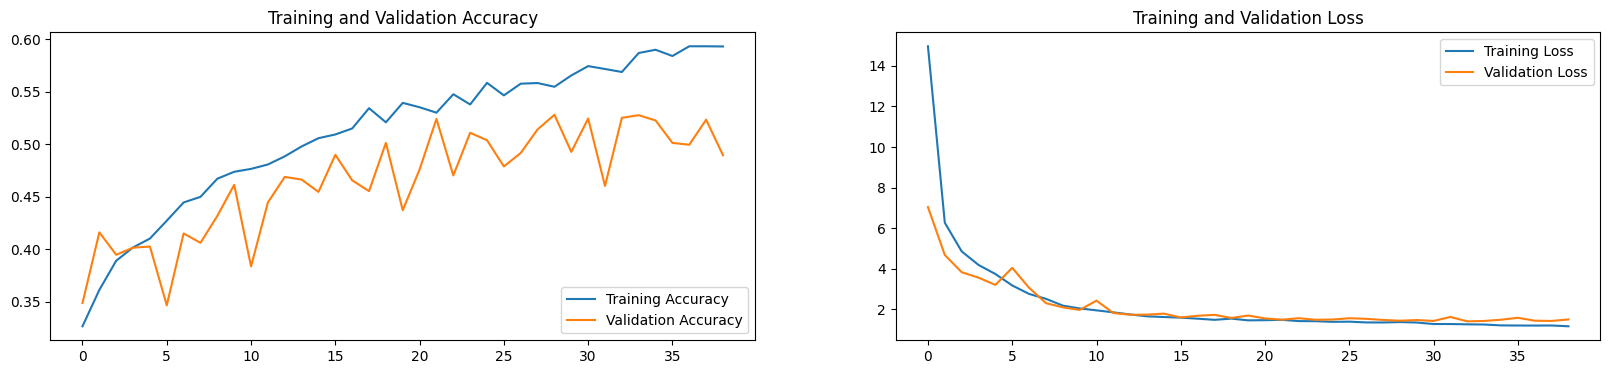

In [ ]:
metrics_compare_plot(loaded_dense_history, len(loaded_dense_history['loss']))

In [ ]:
# Obtener reporte de clasificación
conf_matrix_or_report(loaded_dense_model, test, class_names, conf_matrix=False)

,precision,recall,f1-score,support
buildings,0.415,0.263,0.322,437.000
forest,0.577,0.738,0.648,474.000
glacier,0.533,0.524,0.529,553.000
mountain,0.661,0.383,0.485,525.000
sea,0.300,0.308,0.304,510.000
street,0.431,0.641,0.516,501.000
accuracy,0.478,0.478,0.478,0.478
macro avg,0.486,0.476,0.467,3000.000
weighted avg,0.489,0.478,0.469,3000.000


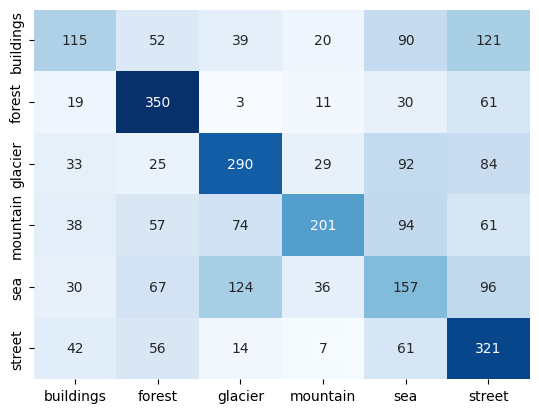

In [ ]:
# Graficar matriz de confusión
conf_matrix_or_report(loaded_dense_model, test, class_names, conf_matrix=True)

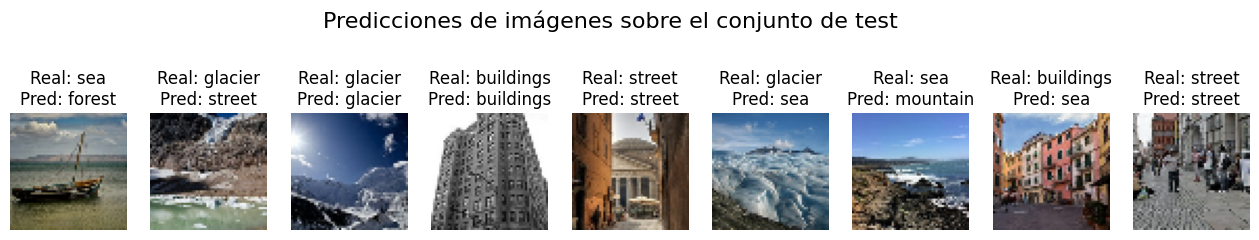

In [ ]:
image_predict(loaded_dense_model, class_names, test)

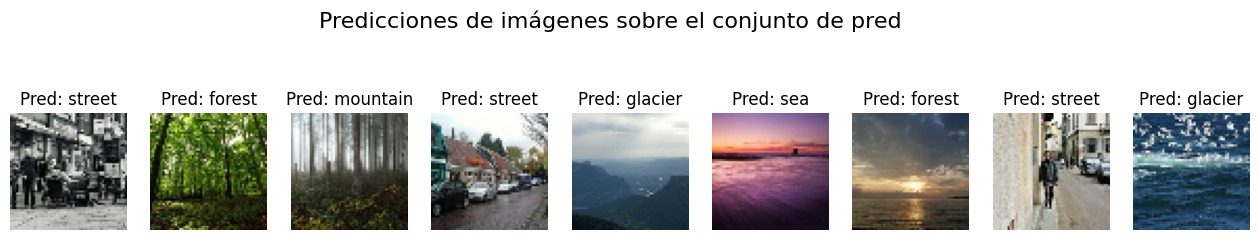

In [ ]:
image_predict(loaded_dense_model, class_names, test, pred=True)

### **Interpretación del rendimiento:**

1.   **Comparación de métricas train y test:** El desempeño general del modelo final fue muy bajo, habiendo un pequeño sobreajuste.
2.   **Evolución de la perdida y precisión:** En los gráficos se puede ver como el accuracy de train va a aumentando suvemente hasta estabilizarse en alredeor de 0.6 y seguido de cerca por el de validación con un poco más de ruido.
3.   **Reporte de clasificación y Matriz de confusión:** Se pude notar que 'forest' fue la clase con mejores resultados y 'sea' la que peores métricas obtuvo. En la matriz se puede observar detalladamente las instancias clasificadas correctamente en la diagonal principal.




---

## **Modelo de capas convolucionales y densas**

In [ ]:
# Función para construir el modelo
def build_conv_model(input_shape, output_labels, dropout_rate=0.3):
    i = Input(input_shape, dtype=tf.float32)

    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)

    x = Conv2D(16, (3, 3))(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(dropout_rate)(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(dropout_rate)(x)

    x = Flatten()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)

    model = tf.keras.Model(inputs=[i], outputs=[x])

    model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

    return model

In [ ]:
print("Building model\n")
conv_model = build_conv_model((image_height, image_width, 3), num_classes)

# Callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')

# Número de épocas de entrenamiento
epochs = 150

# Entrena el modelo
print("Training model")
conv_history = conv_model.fit(
    train_prefetch,
    validation_data=val_prefetch,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

Building model

Training model
Epoch 1/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 2753s 2s/step - accuracy: 0.3953 - loss: 1.4415 - val_accuracy: 0.5973 - val_loss: 1.0242
Epoch 2/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.5976 - loss: 1.0226 - val_accuracy: 0.6711 - val_loss: 0.8789
Epoch 3/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6641 - loss: 0.8886 - val_accuracy: 0.7056 - val_loss: 0.8131
Epoch 4/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6844 - loss: 0.8320 - val_accuracy: 0.7381 - val_loss: 0.7543
Epoch 5/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7318 - loss: 0.7476 - val_accuracy: 0.7434 - val_loss: 0.7302
Epoch 6/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7380 - loss: 0.7156 - val_accuracy: 0.7594 - val_loss: 0.6793
Epoch 7/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7487 - loss: 0.6820 - val_accuracy: 0.7776 - val_loss: 0.6110
Epoch 8/150
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy

### **Interpretación:**

1.  **Estructura del modelo:** Se construyó un modelo convolucional con tres capas de convolución, donde los filtros aumentan progresivamente (16, 32 y 64 filtros). Cada capa de convolución está seguida por una activación ReLU y una capa de MaxPooling que reduce las dimensiones espaciales de las imágenes procesadas. Finalmente, se aplanan las características y se pasa a una capa completamente conectada con activación Softmax para la clasificación de las imágenes en múltiples categorías.

2.  **Regularización y Dropout:** Se utilizó una capa de Dropout con una tasa de 0.3 después de cada operación de MaxPooling y tras la capa de Flatten, con el fin de mitigar el sobreajuste. Este nivel de Dropout fue efectivo para reducir la varianza del modelo sin comprometer su capacidad de generalización.

3.  **Aumento de datos:** Se aplicó aumento de datos mediante la capa RandomFlip, que invierte las imágenes horizontalmente. Esto ayuda a aumentar el tamaño efectivo del conjunto de datos y mejora la robustez del modelo frente a variaciones en la orientación de las imágenes.

4.  **Callback de Early Stopping:** Se implementó un callback de Early Stopping para interrumpir el entrenamiento si la precisión de validación no mejoraba tras 10 épocas. Esto permitió evitar el sobreentrenamiento y reducir el tiempo de entrenamiento al detenerse cuando el modelo alcanzó su mejor rendimiento.

5.  **Resultados obtenidos:** A pesar de la simplicidad del modelo, este diseño logró una precisión adecuada, aunque con la posibilidad de mejoras.

### **Guardar el modelo entrenado y dejar disponible su carga**

In [ ]:
# Guardar el modelo completo
conv_model.save('/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3/conv_model.keras')

# Guardar el history en formato JSON
with open('/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3/conv_model_history.json', 'w') as f:
    json.dump(conv_history.history, f)

In [ ]:
# Cargar el modelo guardado
loaded_conv_model = tf.keras.models.load_model('/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3/conv_model.keras')

# Cargar el history del modelo guardado
with open('/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3/conv_model_history.json', 'r') as f:
    loaded_conv_model_history = json.load(f)

### **Desempeño del modelo entrenado**

In [ ]:
# Comparar la evaluación de train y test
model_evaluate(loaded_conv_model, test, loaded_conv_model_history)

,Train,Test
loss,0.538425,0.556397
accuracy,0.804569,0.799333


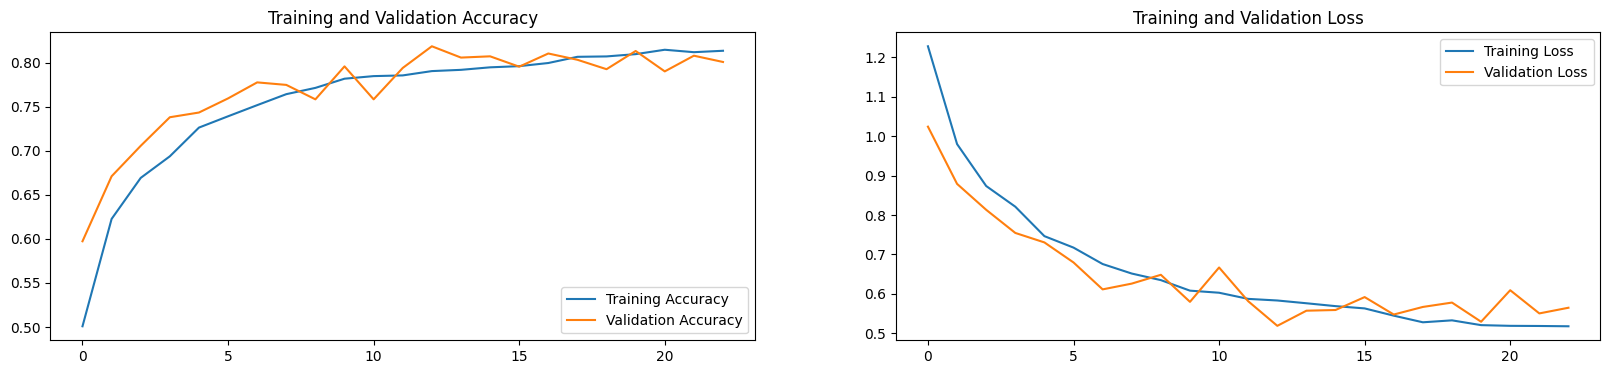

In [ ]:
# Evolución de la perdida y precisión
metrics_compare_plot(loaded_conv_model_history, len(loaded_conv_model_history['loss']))

In [ ]:
# Obtener reporte de clasificación
conf_matrix_or_report(loaded_conv_model, test, class_names, conf_matrix=False)

,precision,recall,f1-score,support
buildings,0.899,0.673,0.770,437.000
forest,0.767,0.985,0.862,474.000
glacier,0.755,0.810,0.782,553.000
mountain,0.729,0.825,0.774,525.000
sea,0.840,0.761,0.798,510.000
street,0.887,0.735,0.803,501.000
accuracy,0.799,0.799,0.799,0.799
macro avg,0.813,0.798,0.798,3000.000
weighted avg,0.810,0.799,0.798,3000.000


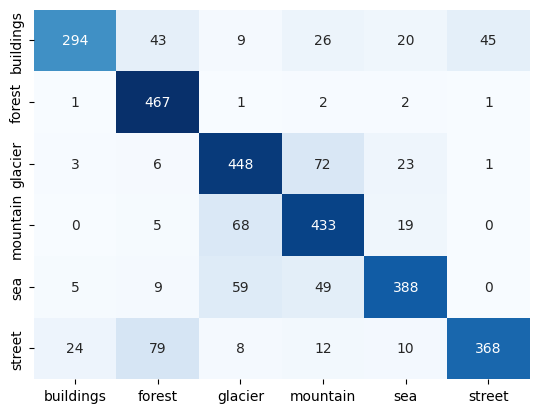

In [ ]:
# Graficar matriz de confusión
conf_matrix_or_report(loaded_conv_model, test, class_names, conf_matrix=True)

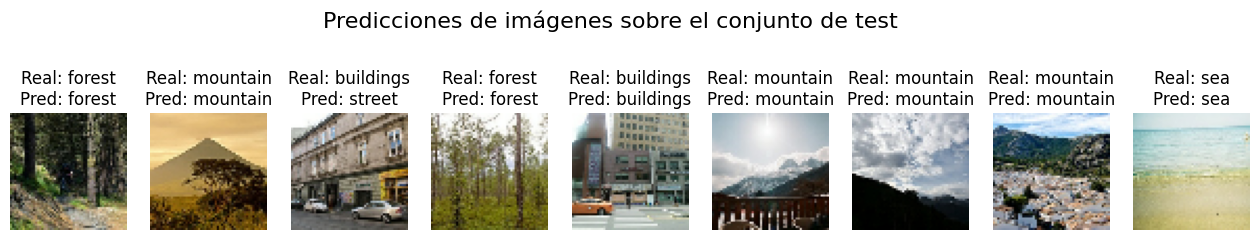

In [ ]:
image_predict(loaded_conv_model, class_names, test)

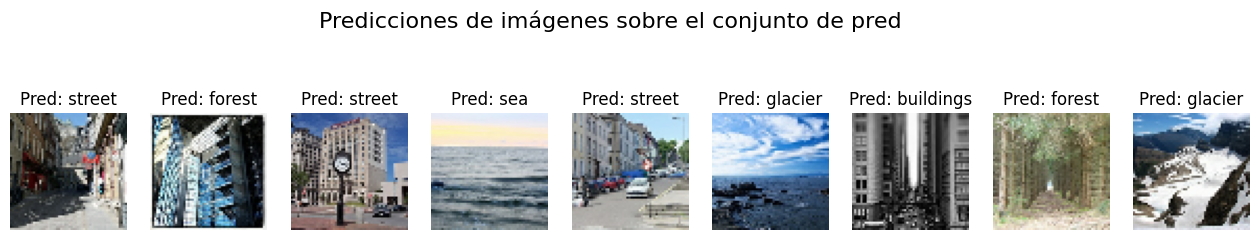

In [ ]:
image_predict(loaded_conv_model, class_names, test, pred=True)

### **Interpretación del rendimiento:**

1.   **Comparación de métricas train y test:**
2.   **Evolución de la perdida y precisión:**
3.   **Reporte de clasificación y Matriz de confusión:**

---
## **Modelo con bloques residuales identidad**

In [ ]:
# Definimos un bloque residual
def residual_block_identity(x, filters):
    # Guardar la entrada para la conexión residual
    shortcut = x

    # Primera convolución
    x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    # Segunda convolución
    x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    # Sumar la entrada a la salida (conexión residual)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

In [ ]:
# Definimos una función para construir el modelo
def build_residual_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Rescaling(1./255)(inputs)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.5)(x)

    x = residual_block_identity(x, 32)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.5)(x)

    x = residual_block_identity(x, 64)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = Activation("relu")(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=['accuracy'])

    return model

In [ ]:
# Costruir el modelo
residual_model = build_residual_model((image_height, image_width, 3), num_classes)

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=0, mode='max')

# Número de épocas de entrenamiento
EPOCHS = 250

# Entrena el modelo
residual_model_history = residual_model.fit(
    train_prefetch,
    validation_data=val_prefetch,
    epochs=EPOCHS,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

Epoch 1/250
351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.2950 - loss: 1.7824 - val_accuracy: 0.1714 - val_loss: 2.7800
Epoch 2/250
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4844 - loss: 1.3100 - val_accuracy: 0.1732 - val_loss: 5.1839
Epoch 3/250
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5524 - loss: 1.1294 - val_accuracy: 0.2185 - val_loss: 3.4775
Epoch 4/250
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6000 - loss: 1.0309 - val_accuracy: 0.1860 - val_loss: 3.2768
Epoch 5/250
351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6299 - loss: 0.9822 - val_accuracy: 0.3239 - val_loss: 2.6559
Epoch 6/250
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6429 - loss: 0.9410 - val_accuracy: 0.3275 - val_loss: 2.6535
Epoch 7/250
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6741 - loss: 0.8668 - val_accuracy: 0.2919 - val_loss: 2.8841
Epoch 8/250
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7001 - loss: 0.8032 - val_ac

### **Interpretación:**

1.  **Estructura del modelo:** Se construyó un modelo basado en bloques residuales, donde las capas convolucionales se benefician de conexiones residuales. Estas conexiones permiten que la entrada original se sume a la salida de las capas convolucionales, mitigando el problema de la degradación del gradiente en redes profundas. Se emplearon dos bloques residuales, cada uno con dos capas convolucionales, lo que permite al modelo aprender características más complejas sin perder información de la entrada original.

2.  **Regularización y Dropout:** Se incluyó una tasa de Dropout del 50% después de las capas de MaxPooling para reducir el riesgo de sobreajuste. Esta tasa alta fue efectiva en mejorar la generalización del modelo en comparación con versiones anteriores, donde se utilizaban tasas más bajas.

3.  **Aumento de datos:** Se utilizó una estrategia de aumento de datos que incluyó rotaciones horizontales y verticales aleatorias, así como ajustes de contraste. Estas técnicas incrementan la robustez del modelo al entrenarlo con versiones modificadas de las imágenes originales.

4.  **Bloques residuales:** Los bloques residuales permitieron que el modelo aprendiera de manera más eficiente al facilitar la transmisión de gradientes hacia capas anteriores, evitando que el modelo se quede atascado en mínimos locales.

5.  **Callback de Early Stopping:** Se empleó un callback de Early Stopping configurado para detener el entrenamiento si la precisión de validación no mejoraba durante 15 épocas consecutivas.

6.  **Resultados obtenidos:** La implementación de bloques residuales y un mayor aumento de datos permitió al modelo alcanzar una precisión superior en comparación con modelos anteriores sin esta arquitectura.

### **Guardar el modelo entrenado y dejar disponible su carga**

In [ ]:
# Guardar el modelo completo
residual_model.save('/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3/residual_model.keras')

# Guardar el history en formato JSON
with open('/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3/residual_model_history.json', 'w') as f:
    json.dump(residual_model_history.history, f)

In [ ]:
# Cargar el modelo guardado
loaded_residual_model = tf.keras.models.load_model('/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3/residual_model.keras')

# Cargar el history del modelo guardado
with open('/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3/residual_model_history.json', 'r') as f:
    loaded_residual_model_history = json.load(f)

### **Desempeño del modelo entrenado**

In [ ]:
# Comparar la evaluación de train y test
model_evaluate(loaded_residual_model, test, loaded_residual_model_history)

,Train,Test
loss,0.460797,3.091753
accuracy,0.833256,0.435667


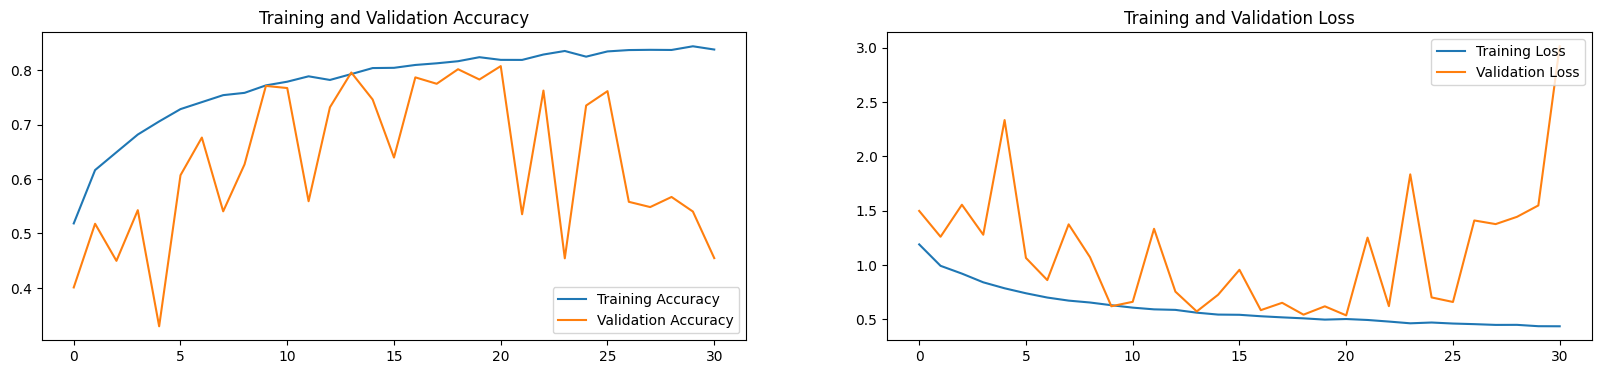

In [ ]:
metrics_compare_plot(loaded_residual_model_history, len(loaded_residual_model_history['loss']))

In [ ]:
# Obtener reporte de clasificación
conf_matrix_or_report(loaded_residual_model, test, class_names, conf_matrix=False)

,precision,recall,f1-score,support
buildings,0.213,0.812,0.338,437.000
forest,0.917,0.816,0.864,474.000
glacier,0.518,0.052,0.095,553.000
mountain,0.474,0.495,0.485,525.000
sea,0.930,0.208,0.340,510.000
street,0.867,0.339,0.488,501.000
accuracy,0.436,0.436,0.436,0.436
macro avg,0.653,0.454,0.435,3000.000
weighted avg,0.657,0.436,0.427,3000.000


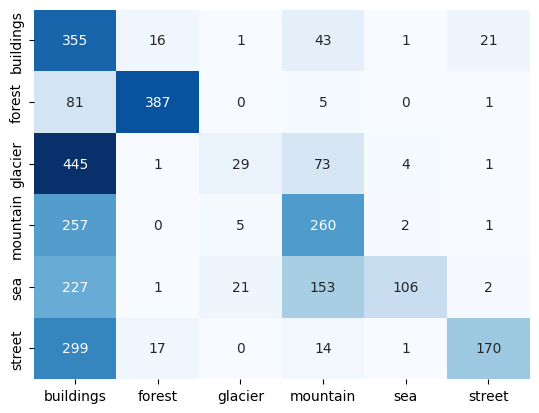

In [ ]:
# Graficar matriz de confusión
conf_matrix_or_report(loaded_residual_model, test, class_names, conf_matrix=True)

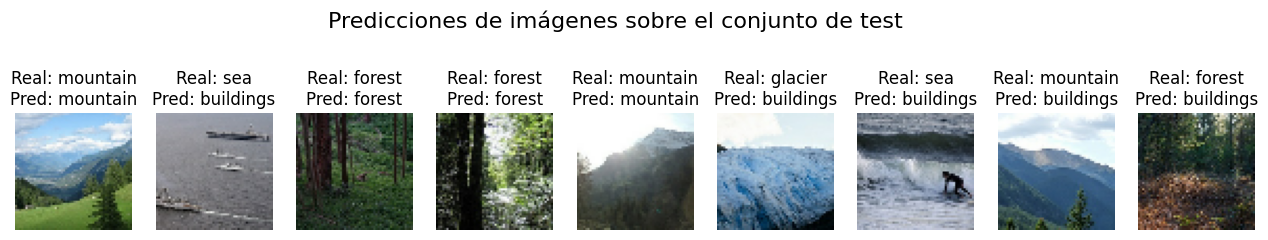

In [ ]:
image_predict(loaded_residual_model, class_names, test)

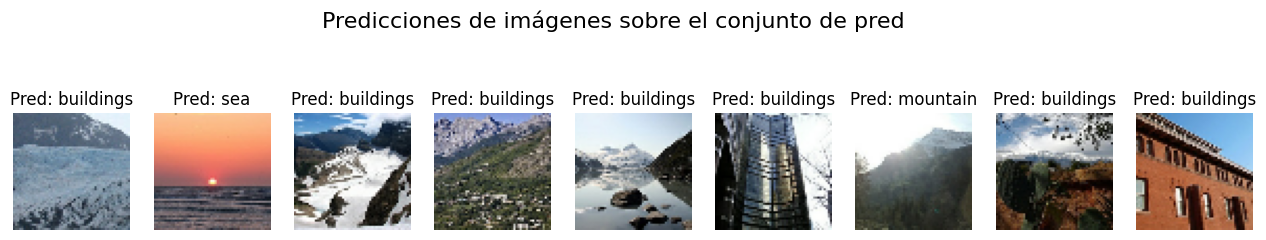

In [ ]:
image_predict(loaded_residual_model, class_names, test, pred=True)

### **Interpretación del rendimiento:**

1.   **Comparación de métricas train y test:**
2.   **Evolución de la perdida y precisión:**
3.   **Reporte de clasificación y Matriz de confusión:**

---
## **Modelo con Backbone**

 https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [9]:
def build_model(input_shape, num_classes):
    base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable = False

    i = Input(shape=input_shape)

    x = tf.keras.applications.efficientnet.preprocess_input(i)

    x = base_model(x, training=False)

    x = GlobalMaxPooling2D()(x)

    # Agregar una capa densa
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Otra capa densa con Batch Normalization
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)

    x = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(i, x)

    model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

    return model

In [10]:
print("Building model")
backbone_model = build_model((image_height, image_width, 3), num_classes)

# Callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')

# Número de épocas de entrenamiento
epochs = 100

# Entrena el modelo
backbone_model_history = backbone_model.fit(
    train_prefetch,
    validation_data=val_prefetch,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

Building model
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 2454s 1s/step - accuracy: 0.4565 - loss: 1.4698 - val_accuracy: 0.8161 - val_loss: 0.5606
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 44s 9ms/step - accuracy: 0.7054 - loss: 0.8180 - val_accuracy: 0.8293 - val_loss: 0.4909
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7586 - loss: 0.6940 - val_accuracy: 0.8378 - val_loss: 0.4677
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7770 - loss: 0.6421 - val_accuracy: 0.8407 - val_loss: 0.4523
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7989 - loss: 0.5917 - val_accuracy: 0.8478 - val_loss: 0.4366
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8056 - loss: 0.5758 - val_accuracy: 0.8471 - val_loss: 0.4268
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8127 - loss: 0.5415 - val_accuracy: 0.8482 - val_loss: 0.4279
Epoch 8/100
351/351 ━━━━━━━

### **Guardar el modelo entrenado y dejar disponible su carga**

In [ ]:
# Guardar el modelo completo
backbone_model.save('/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3/backbone_model.keras')

# Guardar el history en formato JSON
with open('/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3/backbone_history.json', 'w') as f:
    json.dump(backbone_model_history.history, f)

In [ ]:
# Cargar el modelo guardado
loaded_backbone_model = tf.keras.models.load_model('/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3/backbone_model.keras')

# Cargar el history del modelo guardado
with open('/content/drive/MyDrive/Aprendizaje 2/TP1/TP-EJ3/backbone_history.json', 'r') as f:
    loaded_backbone_model_history = json.load(f)

### **Desempeño del modelo entrenado**

In [ ]:
# Comparar la evaluación de train y test
model_evaluate(loaded_backbone_model, test, loaded_backbone_model_history)

,Train,Test
loss,0.238852,0.561837
accuracy,0.913653,0.841667


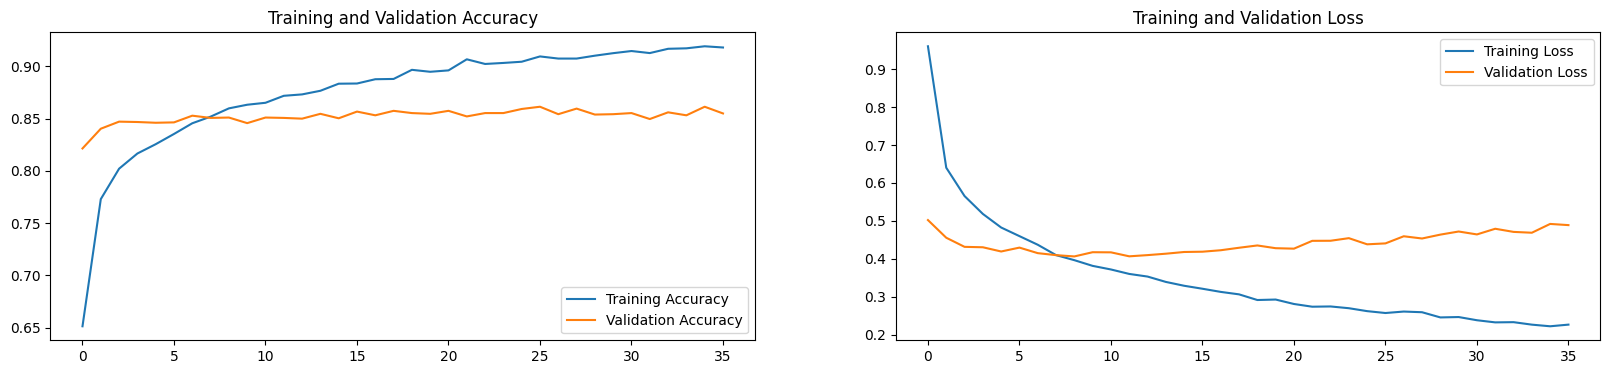

In [ ]:
metrics_compare_plot(loaded_backbone_model_history, len(loaded_backbone_model_history['loss']))

In [ ]:
# Obtener reporte de clasificación
conf_matrix_or_report(loaded_backbone_model, test, class_names, conf_matrix=False)

,precision,recall,f1-score,support
buildings,0.872,0.824,0.847,437.000
forest,0.965,0.981,0.973,474.000
glacier,0.821,0.698,0.755,553.000
mountain,0.764,0.783,0.773,525.000
sea,0.811,0.886,0.847,510.000
street,0.835,0.900,0.866,501.000
accuracy,0.842,0.842,0.842,0.842
macro avg,0.845,0.845,0.844,3000.000
weighted avg,0.842,0.842,0.840,3000.000


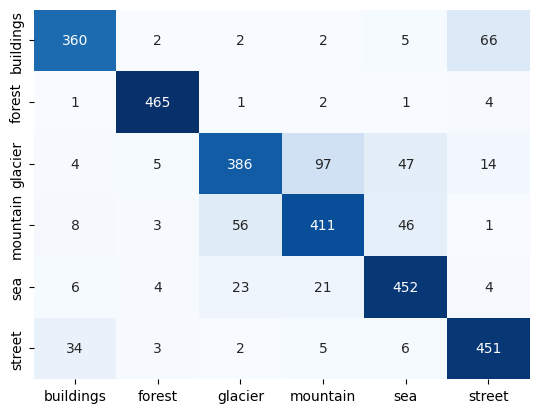

In [ ]:
# Graficar matriz de confusión
conf_matrix_or_report(loaded_backbone_model, test, class_names, conf_matrix=True)

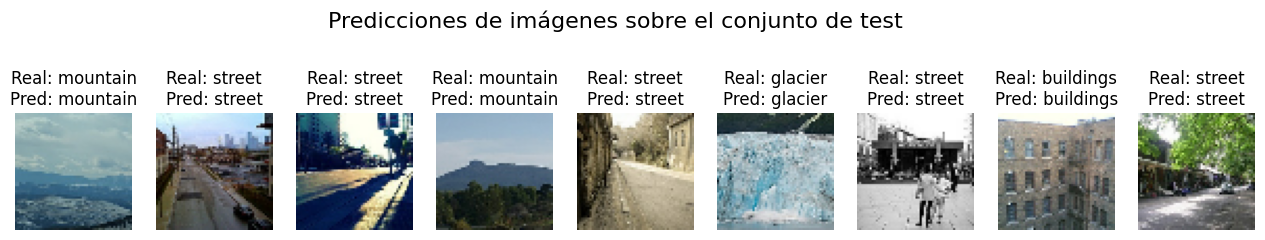

In [ ]:
image_predict(loaded_backbone_model, class_names, test)

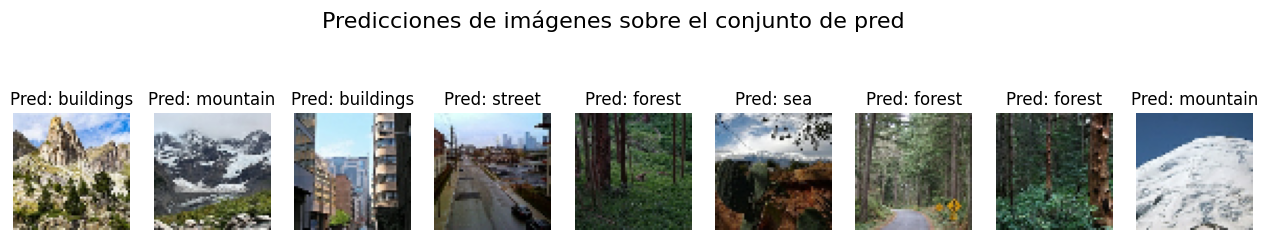

In [ ]:
image_predict(loaded_backbone_model, class_names, test, pred=True)

### **Interpretación del rendimiento:**

1.   **Comparación de métricas train y test:**
2.   **Evolución de la perdida y precisión:**
3.   **Reporte de clasificación y Matriz de confusión:**